In [1]:
from datasets import load_dataset

ds = load_dataset("ninadn/indian-legal")

In [2]:
ds_train = ds['train'].select(range(100))

In [3]:
text_len = [len(x['Text'].split()) for x in ds_train]
summary_len = [len(x['Summary'].split()) for x in ds_train]

array([[<Axes: title={'center': 'Text Length'}>,
        <Axes: title={'center': 'Summary Length'}>]], dtype=object)

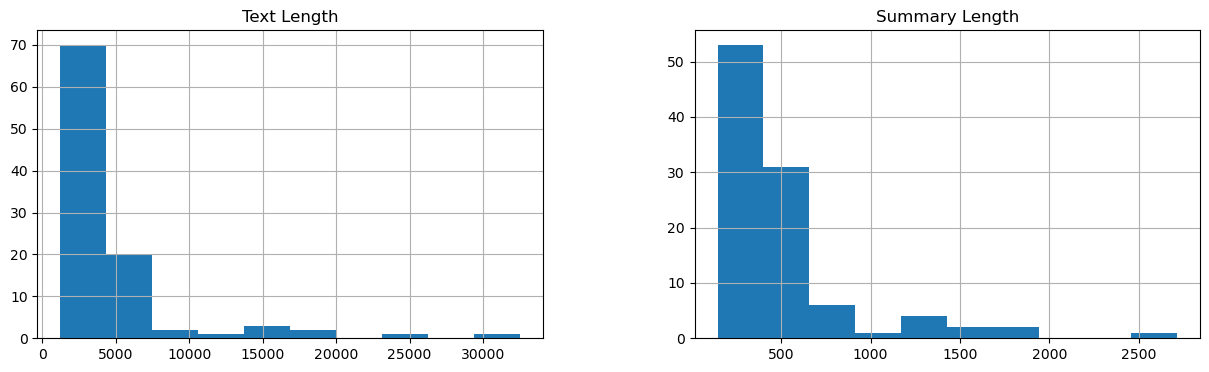

In [4]:
import pandas as pd

data = pd.DataFrame([text_len, summary_len]).T
data.columns = ['Text Length', 'Summary Length']

data.hist(figsize=(15,4))

In [5]:
from datasets import load_dataset
from transformers import pipeline

from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
import torch

In [6]:
model_ckpt = 'facebook/bart-large-cnn'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt)

/Users/hari/anaconda3/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [7]:
def get_feature(batch):
  encodings = tokenizer(batch['Text'], text_target=batch['Summary'],
                        max_length=1024, truncation=True)

  encodings = {'input_ids': encodings['input_ids'],
               'attention_mask': encodings['attention_mask'],
               'labels': encodings['labels']}

  return encodings

In [8]:
ds_pt = ds_train.map(get_feature, batched=True)

In [9]:
ds_pt_test = ds['test'].map(get_feature, batched=True)

In [10]:
columns = ['input_ids', 'labels', 'attention_mask']
ds_pt.set_format(type='torch', columns=columns)

In [11]:
ds_pt

Dataset({
    features: ['Text', 'Summary', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 100
})

In [12]:
from transformers import DataCollatorForSeq2Seq
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [13]:
import torch

if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

In [14]:
model.to(device)

BartForConditionalGeneration(
  (model): BartModel(
    (shared): BartScaledWordEmbedding(50264, 1024, padding_idx=1)
    (encoder): BartEncoder(
      (embed_tokens): BartScaledWordEmbedding(50264, 1024, padding_idx=1)
      (embed_positions): BartLearnedPositionalEmbedding(1026, 1024)
      (layers): ModuleList(
        (0-11): 12 x BartEncoderLayer(
          (self_attn): BartSdpaAttention(
            (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (fc2): Linear(in_features=4096, out_features=1024, bias=True)
    

In [15]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir = 'bart-Inlegal',
    num_train_epochs=1,
    warmup_steps = 500,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    weight_decay = 0.01,
    logging_steps = 10,
    evaluation_strategy = 'steps',
    eval_steps=500,
    save_steps=1e6,
    gradient_accumulation_steps=16
)

trainer = Trainer(model=model, args=training_args, tokenizer=tokenizer, data_collator=data_collator,
                  train_dataset = ds_pt, eval_dataset = ds_pt_test)

/Users/hari/anaconda3/lib/python3.11/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
trainer.evaluate()